# Simulated Datasets with different source voltages and same filters

In this notebook, we provide an example about how to use the parametric-based model to reconstruction X-ray spectral energy response with known objects.

In [1]:
# Basic Packages
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import svmbir
import h5py

from xspec.chem_consts import get_lin_att_c_vs_E
from xspec.dictSE import cal_fw_mat
from xspec._utils import Gen_Circle
import spekpy as sp  # Import SpekPy
from xspec.defs import *
from xspec import paramSE
from xspec.chem_consts._periodictabledata import density

import torch

## A. Generate simulated phantom with 3 different metal materials.

In [2]:
# Pixel size in mm units. 
rsize = 0.01  # mm

# Number of channels in detector
nchanl = 1024

# Scanned cylinders
materials = ['V', 'Al','Ti','Mg']
mat_density = [density['%s' % formula] for formula in materials] # g/cm³

# 5 cylinders are evenly distributed on a circle 
Radius = [1 for _ in range(len(materials))]
arrange_with_radius = 3
centers = [[np.sin(rad_angle)* arrange_with_radius, np.cos(rad_angle)* arrange_with_radius] 
           for rad_angle in np.linspace(-np.pi/2,-np.pi/2+np.pi*2,len(materials),endpoint=False)]

# Simulated sinogram parameters
num_views = 40
tilt_angle = np.pi / 2  # Tilt range of +-90deg
# Generate the array of view angles
angles = np.linspace(-tilt_angle, tilt_angle, num_views, endpoint=False)

# Each mask represents a homogenous cylinder.
mask_list = []
for mat_id, mat in enumerate(materials):
    circle = Gen_Circle((nchanl, nchanl), (rsize, rsize))
    mask_list.append(circle.generate_mask(Radius[mat_id], centers[mat_id])[np.newaxis])


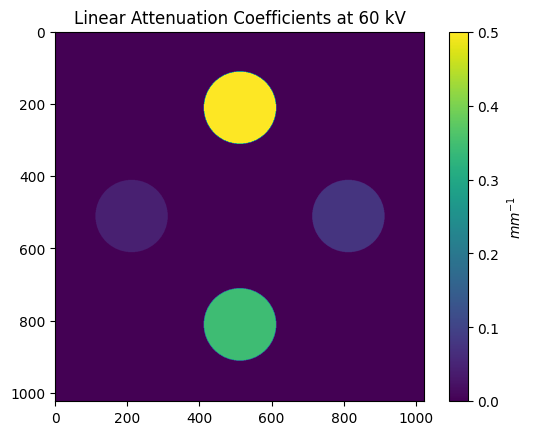

In [3]:
plt.imshow(np.sum(np.array([ml*get_lin_att_c_vs_E(mat_density[i], materials[i], 60.0) for i, ml in enumerate(mask_list)]), axis=(0,1)), vmin=0, vmax=0.5)

# Adding a colorbar
cbar = plt.colorbar()
cbar.set_label('$mm^{-1}$')  # Label for the colorbar

# Optional: Add title and axis labels
plt.title('Linear Attenuation Coefficients at 60 kV')
plt.show()

## B.Generate ground truth X-ray spectral energy resposne

### B.0 Generate a dictionary of source spectra.

Use Spekpy to generate a dictionary. https://bitbucket.org/spekpy/spekpy_release/wiki/Home

Source voltage is range from 30 kV to 200 kV.

Anode angle or take-off angle is 20 degree.


Running demo script (10 mAs, 100 cm)


Finished!



<Figure size 640x480 with 0 Axes>

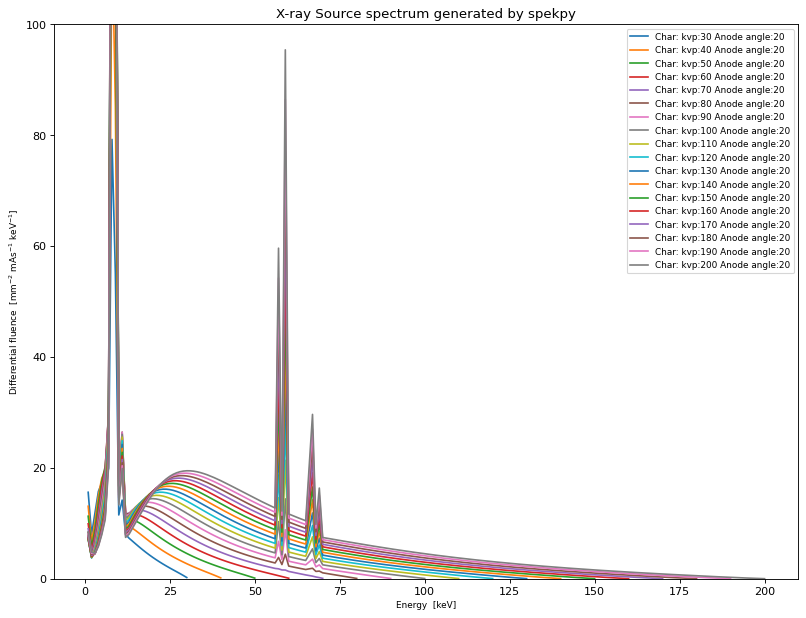

In [14]:
simkV_list = np.linspace(30, 200, 18, endpoint=True).astype('int')
max_simkV = max(simkV_list)

takeoff_angle = 20
# Energy bins.
energies = np.linspace(1, max_simkV, max_simkV)

# Use Spekpy to generate a source spectra dictionary.
src_spec_list = []
plt.figure(2)
fig, axs = plt.subplots(1, 1, figsize=(12, 9), dpi=80)
print('\nRunning demo script (10 mAs, 100 cm)\n')
for simkV in simkV_list:
    s = sp.Spek(kvp=simkV + 1, th=takeoff_angle, dk=1, mas=1, char=True)  # Create the spectrum model
    k, phi_k = s.get_spectrum(edges=True)  # Get arrays of energy & fluence spectrum
    phi_k = phi_k * ((rsize / 10) ** 2)
    ## Plot the x-ray spectrum
    axs.plot(k[::2], phi_k[::2],
             label='Char: kvp:%d Anode angle:%d' % (simkV, takeoff_angle))
    src_spec = np.zeros((max_simkV))
    src_spec[:simkV] = phi_k[::2]
    src_spec_list.append(src_spec)

print('\nFinished!\n')
axs.set_xlabel('Energy  [keV]', fontsize=8)
axs.set_ylim((0,1E2))
axs.set_ylabel('Differential fluence  [mm$^{-2}$ mAs$^{-1}$ keV$^{-1}$]', fontsize=8)
axs.set_title('X-ray Source spectrum generated by spekpy')
axs.legend(fontsize=8)

# A dictionary of source spectra with source voltage from 30 kV to 200 kV
src_spec_list = np.array(src_spec_list)

### B.1 Source Model
Use 3 source voltages: 50 kV, 100 kV, 150 kV

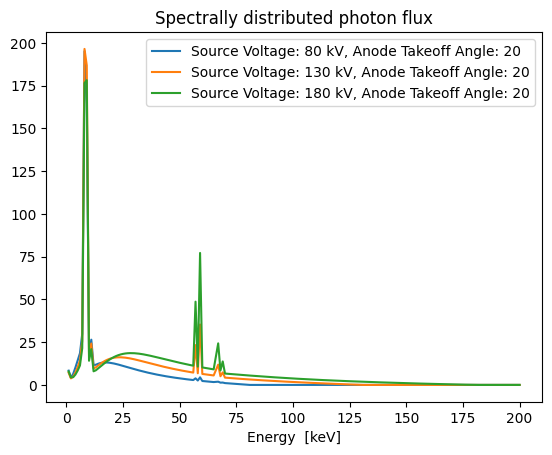

In [15]:
num_src_v = 3
voltage_list = [80.0, 130.0, 180.0] # kV
# Bound is a python structure to store the possible range for a continuous variable.
src_vol_bound = Bound(lower=30.0, upper=200.0)
takeoff_angle_bound = Bound(lower=5.0, upper=45.0)

# Source is a python structure to store a source's parameters, including 
# energy bins, kV list and corresponding source spectral dictionary, bound of source voltage, and source voltage.
Src_config = [Source(energies, simkV_list, takeoff_angle, src_spec_list,
                     src_vol_bound, takeoff_angle_bound, voltage=vv, takeoff_angle=takeoff_angle,
                     optimize_voltage=False, optimize_takeoff_angle=False) for vv in
              voltage_list]

ref_src_spec_list = []
for sc in Src_config:
    # Pass a source's parameters to Source_Model. 
    src_model = paramSE.Source_Model(sc)
    with (torch.no_grad()):
        # Forward function of the Source_Model is the source spectrum/spectrally distributed photon flux.
        ref_src_spec_list.append(src_model(energies).data.numpy())
        plt.plot(energies, src_model(energies).data, label = 'Source Voltage: %d kV, Anode Takeoff Angle: %d'%(sc.voltage, takeoff_angle))
plt.title('Spectrally distributed photon flux')
plt.xlabel('Energy  [keV]')
plt.legend()


### B.2 Filter Model

A filter is used:
* 3 mm Al

In [16]:
fltr_th_bound = Bound(lower=0.0, upper=10.0)  # 0.0 ~ 10.0 mm

fltr_th = 3.0 # mm

# Filter is a python structure to store a filter's parameters.
Fltr_config = [Filter([], fltr_th_bound, fltr_mat=Material(formula='Al', density=2.702),fltr_th=fltr_th),
              ]

Text(0.5, 0, 'Energy  [keV]')

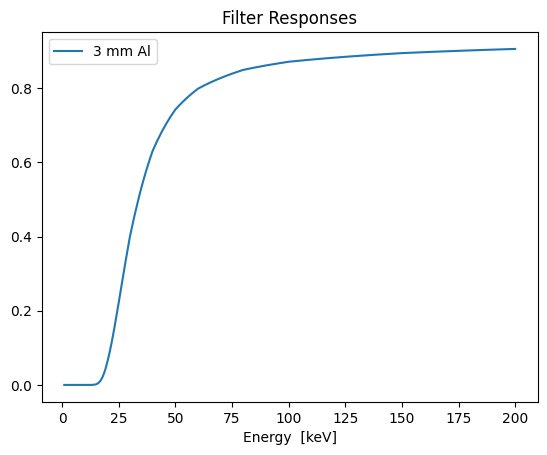

In [17]:
ref_fltr_resp_list = []
for fci, fr in enumerate(Fltr_config):
    # Forward function of the Filter_Model is the filter response.
    fltr_model = paramSE.Filter_Model(fr)
    with (torch.no_grad()):
        ref_fltr_resp_list.append(fltr_model(energies).data.numpy())
        plt.plot(energies, fltr_model(energies).data, label='%d mm %s'%(fr.fltr_th, fr.fltr_mat.formula))
plt.title('Filter Responses')
plt.legend()
plt.xlabel('Energy  [keV]')

### B.3 Scintillator model

In [18]:
scint_th_bound = Bound(lower=0.01, upper=0.5)
# Use Lu3Al5O12, the third scintillator, as ground truth scintillator.
# Scintillator is a python structure to store a scintillator's parameters.
Scint_config = [Scintillator([], scint_th_bound, scint_mat=Material(formula='CsI', density=4.51), scint_th = 0.33)]

Text(0.5, 0, 'Energy  [keV]')

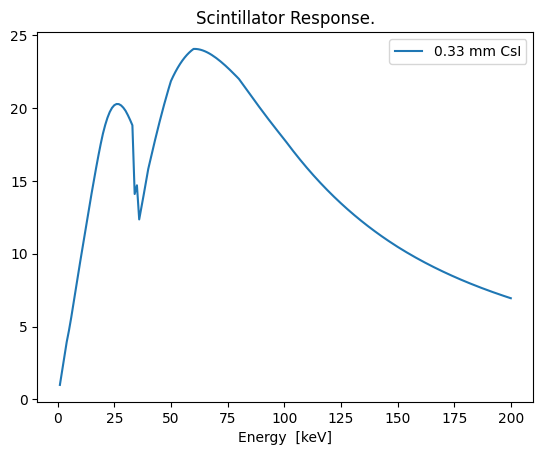

In [19]:
ref_scint_cvt_list = []
for st in Scint_config:
    # Forward function of the Scintillator_Model is the scintillator response.
    scint_model = paramSE.Scintillator_Model(st)
    with (torch.no_grad()):
        ref_scint_cvt_list.append(scint_model(energies).data.numpy())
        plt.plot(energies, scint_model(energies).data, label='%.2f mm %s'%(st.scint_th, st.scint_mat.formula))
plt.title('Scintillator Response.')
plt.legend()
plt.xlabel('Energy  [keV]')

### B.4 Use registrated sources, filters, and scintillators to define an experiment.

In this experiment, we have
* 3 sources: src_0, src_1, src_2
* 1 filter: fltr_0
* 1 scintilla
tor: scint_0

We want to scan 3 datasets with below setting:
* src_0 + [fltr_0] + scint_0
* src_1 + [fltr_0] + scint_0
* src_2 + [fltr_0] + scint_0

Result in 3 different X-ray spectral energy response.

In [20]:
model_combination = [Model_combination(src_ind=0, fltr_ind_list=[0], scint_ind=0),
                     Model_combination(src_ind=1, fltr_ind_list=[0], scint_ind=0),
                     Model_combination(src_ind=2, fltr_ind_list=[0], scint_ind=0),
                    ]

Text(0.5, 0, 'Energy  [keV]')

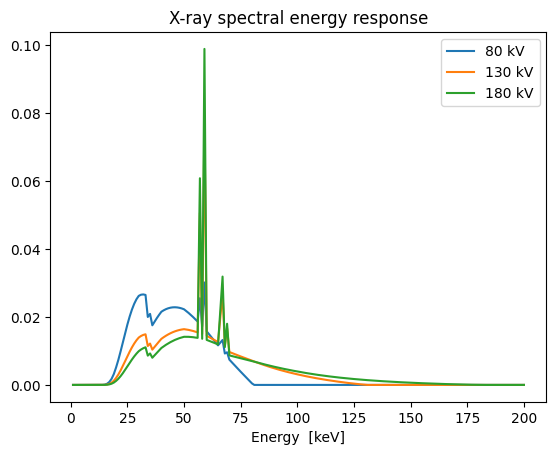

In [21]:
gt_spec_list= []
ll = [ '80 kV', '130 kV', '180 kV']
i = 0
for mc in model_combination:
    src_s = ref_src_spec_list[mc.src_ind]
    fltr_s = ref_fltr_resp_list[mc.fltr_ind_list[0]]
    for fii in mc.fltr_ind_list[1:]:
        fltr_s=fltr_s*ref_fltr_resp_list[fii]
    scint_s  = ref_scint_cvt_list[mc.scint_ind]
    gt_spec = src_s*fltr_s*scint_s
    gt_spec /= np.trapz(gt_spec, energies, axis=-1)
    gt_spec_list.append(gt_spec)
    plt.plot(energies, gt_spec, label=ll[i])
    i+=1
plt.legend()
plt.title('X-ray spectral energy response')
plt.xlabel('Energy  [keV]')

## C. Generate simulated datasets with above 3 reponses.

In [22]:
# Customerize forward projector with a forward function that do forwald projection of a given mask.
class fw_projector:
    def __init__(self, angles, num_channels, delta_pixel=1, geometry='parallel'):
        """

        Parameters
        ----------
        energies
        N_views
        psize
        xcenter
        geometry
        arange
        """
        self.angles = angles
        self.num_channels = num_channels
        self.delta_pixel = delta_pixel
        self.geometry = geometry

    def forward(self, mask):
        """

        Parameters
        ----------
        mask : numpy.ndarray
            3D mask for pure solid object.

        Returns
        -------
        lai : numpy.ndarray
            Linear attenuation integral, of size M measurement * N energy bins.

        """

        projections = svmbir.project(mask, self.angles, self.num_channels) * self.delta_pixel

        return projections

Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/d27aade591ab2e55e19c.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/d27aade591ab2e55e19c.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/d27aade591ab2e55e19c.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/d27aade591ab2e55e19c.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/d27aade591ab2e55e19c.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/d27aade591ab2e55e19c.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/d27aade591ab2e55e19c.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/d27aade591ab2e55e19c.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/d27aade591ab2e55e19c.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/d27aade591ab2e55e19c.2Dsvmatrix
Found system matrix: /Users/damonli/.cache/svmbir/sysmatrix/d27aade591ab2e55e19c

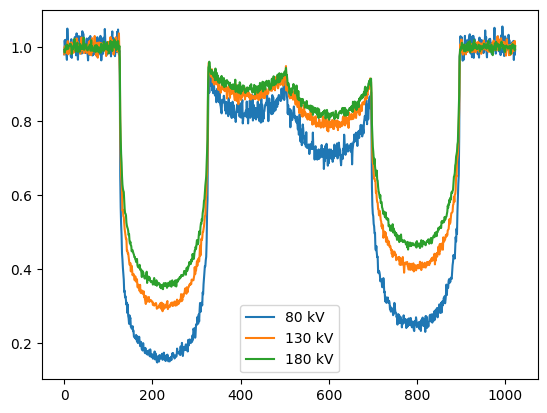

In [23]:
with h5py.File('../../../sim_data/sim_3v1f1s_dataset.hdf5' , 'w') as f:
    for case_i, gt_spec, mc in zip(np.arange(len(gt_spec_list)), gt_spec_list, model_combination):

        spec_F_train_list = []
        trans_list = []

        lac_vs_E_list = []
        # Each mask represents a homogenous cylinder.
        # Each lac_vs_E represents the homogenous material's linear attenuation coefficient.
        for i in range(len(mask_list)):
            formula = materials[i]
            den = mat_density[i]
            lac_vs_E_list.append(get_lin_att_c_vs_E(den, formula, energies))

        # SVMBIR Forward Projector, you can use your customerize forward projector.
        pfp = fw_projector(angles, num_channels=nchanl, delta_pixel=rsize)
        # Forward Matrix F. cal_fw_mat uses given forward projector, LAC value, 
        # and masks of homogenous objects to calculate a forward matrix.
        spec_F = cal_fw_mat(mask_list, lac_vs_E_list, energies, pfp)
        
        # Decomposed Source-Filter-Scintillator Model
        src_s = ref_src_spec_list[mc.src_ind]
        fltr_s = ref_fltr_resp_list[mc.fltr_ind_list[0]]
        for fii in mc.fltr_ind_list[1:]:
            fltr_s=fltr_s*ref_fltr_resp_list[fii]
        scint_s  = ref_scint_cvt_list[mc.scint_ind]
        
        # Add poisson noise before reaching detector/scintillator.
        trans = np.trapz(spec_F * src_s * fltr_s* scint_s, energies, axis=-1)
        trans_0 = np.trapz(src_s * fltr_s* scint_s, energies, axis=-1)
        trans_noise = np.random.poisson(trans).astype(np.float64)
        trans_noise /= trans_0   
            
        
        # Store noiseless transmission data and forward matrix.
        trans_list.append(trans_noise)
        spec_F_train = spec_F.reshape((-1, spec_F.shape[-1]))
        spec_F_train_list.append(spec_F_train)
        spec_F_train_list = np.array(spec_F_train_list)
        trans_list = np.array(trans_list)
        
        plt.plot(trans_list[0][16,0], label=ll[case_i])

        # Save simulated dataset to h5py file.
        src_dict_h5 = {
            'energies': energies,
            'src_spec': ref_src_spec_list[mc.src_ind],
            'voltage' : float(Src_config[mc.src_ind].voltage)
        }

        
        fltr_dict_h5 = {}

        for i in mc.fltr_ind_list:
            fltr_dict_h5['fltr_mat_0_formula'] = Fltr_config[i].fltr_mat.formula
            fltr_dict_h5['fltr_mat_0_density'] = Fltr_config[i].fltr_mat.density
            fltr_dict_h5['fltr_mat_0_th'] = Fltr_config[i].fltr_th


        scint_dict_h5 = {
            'scint_th':Scint_config[mc.scint_ind].scint_th,
            'scint_mat_formula' : Scint_config[mc.scint_ind].scint_mat.formula,
            'scint_mat_density' : Scint_config[mc.scint_ind].scint_mat.density
        }

        d = {
            'measurement': trans_list,
            'forward_mat': spec_F_train_list,
            'src_config' : src_dict_h5,
            'fltr_config': fltr_dict_h5,
            'scint_config': scint_dict_h5,
        }

        # Write to HDF5 file
        grp_i = f.create_group('case '+str(case_i))
        for key, value in d.items():
            if isinstance(value, dict):
                grp = grp_i.create_group(key)
                for k, v in value.items():
                    grp.attrs[k] = v
            else:
                grp_i.create_dataset(key, data=value)
    plt.legend()

# Spectral Estimation

## A. Read datasets

In [25]:
def read_mv_hdf5(file_name):
    data = []
    with h5py.File(file_name, 'r') as f:
        for key in f.keys():
            grp_i = f[key]
            dict_i = {}
            for sub_key in grp_i.keys():
                if isinstance(grp_i[sub_key], h5py.Group):
                    dict_i[sub_key] = {k: v for k, v in grp_i[sub_key].attrs.items()}
                else:
                    dict_i[sub_key] = np.array(grp_i[sub_key])
            data.append(dict_i)
    return data

In [26]:
# Read dataset.
data = read_mv_hdf5('../../../sim_data/sim_3v1f1s_dataset.hdf5')
signal_train_list = [d['measurement'] for d in data]
spec_F_train_list = [d['forward_mat'] for d in data]

# Number of datasets
num_dataset = len(signal_train_list) 

## B. X-ray System Model

### B.1 Source Model

In [41]:
voltage_list = [80.0,130.0,180.0]
simkV_list = np.linspace(30, 200, 18, endpoint=True).astype('int')
max_simkV = max(simkV_list)
base_anode_angle = 12

# Energy bins.
energies = np.linspace(1, max_simkV, max_simkV)

# Use Spekpy to generate a source spectra dictionary.
src_spec_list = []
# fig, axs = plt.subplots(1, 1, figsize=(12, 9), dpi=80)
print('\nRunning demo script (1 mAs, 100 cm)\n')
for simkV in simkV_list:
    s = sp.Spek(kvp=simkV + 1, th=base_anode_angle, dk=1,mas=1, char=True)  # Create the spectrum model
    k, phi_k = s.get_spectrum(edges=True)  # Get arrays of energy & fluence spectrum
    phi_k = phi_k*((rsize/10)**2)
    src_spec = np.zeros((max_simkV))
    src_spec[:simkV] = phi_k[::2]
    src_spec_list.append(src_spec)

print('\nFinished!\n')

# Use class Source to store a source's paramter.
# optimize=False means do not optimize source voltage.
src_vol_bound = Bound(lower=30.0, upper=200.0)
takeoff_angle_bound = Bound(lower=5.0, upper=45.0)
Src_config = [Source(energies, simkV_list, base_anode_angle, src_spec_list,
                     src_vol_bound, takeoff_angle_bound, voltage=vv,
                     optimize_voltage=False, optimize_takeoff_angle=True) for vv in
              voltage_list]


Running demo script (1 mAs, 100 cm)


Finished!



### B.2 Filter Model

In [42]:
# There is 1 filter with 2 possible materials.
num_fltr = 1
psb_fltr_mat_comb =[Material(formula='Al', density=2.702), Material(formula='Cu', density=8.92)]
fltr_th_bound = Bound(lower=0.0, upper=10.0)
Fltr_config = [Filter(psb_fltr_mat_comb, fltr_th_bound) for i in range(num_fltr)]

### B.3 Scintillator Model

In [43]:
# 7 possible scintillators
scint_params = [
    {'formula': 'CsI', 'density': 4.51},
    {'formula': 'Gd3Al2Ga3O12', 'density': 6.63},
    {'formula': 'Lu3Al5O12', 'density': 6.73},
    {'formula': 'CdWO4', 'density': 7.9},
    {'formula': 'Y3Al5O12', 'density': 4.56},
    {'formula': 'Bi4Ge3O12', 'density': 7.13},
    {'formula': 'Gd2O2S', 'density': 7.32}
]

psb_scint_mat = [Material(formula=scint_p['formula'], density=scint_p['density']) for scint_p in scint_params]
scint_th_bound = Bound(lower=0.01, upper=0.5)
Scint_config = [Scintillator(psb_scint_mat, scint_th_bound)]

### B.4 Use registrated sources, filters, and scintillators to define an experiment.

In this experiment, we have
* 3 sources: src_0, src_1, src_2
* 1 filter: fltr_0
* 1 scintillator: scint_0

We want to scan 3 datasets with below setting:
* src_0 + [fltr_0] + scint_0
* src_1 + [fltr_0] + scint_0
* src_2 + [fltr_0] + scint_0

Result in 3 different X-ray spectral energy response.


In [44]:
model_combination = [Model_combination(src_ind=i, fltr_ind_list=[0], scint_ind=0) for i in range(num_dataset)]

## C. Optimziation parameters

In [45]:
learning_rate =1
optimizer_type = 'NNAT_LBFGS'
loss_type = 'mse' # Least-Square

## D. Parametric-Based Spectral Estimation

In [46]:
savefile_name = 'case_mv_%s_%s_lr%.0e' % (optimizer_type, loss_type, learning_rate)

os.makedirs('./output_3_source_voltages/log/',exist_ok=True)

res = paramSE.param_based_spec_estimate(energies,
                                    signal_train_list,
                                    spec_F_train_list,
                                    Src_config,
                                    Fltr_config,
                                    Scint_config,
                                    model_combination,
                                    weight=None,
                                    learning_rate=learning_rate,
                                    max_iterations=200,
                                    stop_threshold=1e-6,
                                    optimizer_type=optimizer_type,
                                    loss_type=loss_type,
                                    logpath='./output_3_source_voltages/log/%s' % savefile_name,
                                    num_processes=8,
                                    return_history=False)

Number of parallel optimizations: 14
Optimal Result:
Cost: 0.0001901717041619122
Source 0: Voltage: 80.00; Take-off Angle: 19.39
Source 1: Voltage: 130.00; Take-off Angle: 19.39
Source 2: Voltage: 180.00; Take-off Angle: 19.39
Filter 0: Material: Material(formula='Al', density=2.702), Thickness: 2.9845073223114014
Scintillator 0: Material:Material(formula='CsI', density=4.51) Thickness:0.3305796980857849


In [48]:
cost_list = [r[1] for r in res]
optimal_cost_ind = np.argmin(cost_list)
best_res = res[optimal_cost_ind][2]

In [49]:
best_res

spec_distrb_energy_resp(
  (src_spec_list): ModuleList(
    (0-2): 3 x Source_Model()
  )
  (fltr_resp_list): ModuleList(
    (0): Filter_Model()
  )
  (scint_cvt_list): ModuleList(
    (0): Scintillator_Model()
  )
)

# Compare estiamted spectrum with ground truth

## Estimated Parameters

tensor(2.9845)

In [63]:
# Define the data for each section
source_data = [
    ["Source Parameters", "GT", "Estimated"],
    ["Voltage 1(kV)", 80, "/"],
    ["Voltage 2(kV)", 130, "/"],
    ["Voltage 3(kV)", 180, "/"],
    ["Takeoff Angle(°)", 20, best_res.src_spec_list[0].get_takeoff_angle()]
]

filter_data = [
    ["Filter 1 Parameters", "GT", "Estimated"],
    ["material", "Al", best_res.fltr_resp_list[0].get_fltr_mat().formula],
    ["thickness(mm)", 3, best_res.fltr_resp_list[0].get_fltr_th().data]
]

scintillator_data = [
    ["Scintillator Parameters", "Parameter", "Value"],
    ["material", "CsI",best_res.scint_cvt_list[0].get_scint_mat().formula],
    ["thickness(mm)", 0.33, best_res.scint_cvt_list[0].get_scint_th().data]
]

# Function to print a section of the table
def print_section(data):
    # Determine the maximum width for each column
    col_widths = [max(len(str(row[i])) for row in data) for i in range(len(data[0]))]
    # Create a format string for each row
    row_format = " | ".join(["{:<" + str(width) + "}" for width in col_widths])
    
    # Print the header row
    print(row_format.format(*data[0]))
    print('-' * sum(col_widths))  # Separator
    
    # Print each data row
    for row in data[1:]:
        print(row_format.format(*row))
    print()  # Add a blank line after the section

# Print the table sections
print_section(source_data)
print_section(filter_data)
print_section(scintillator_data)


Source Parameters | GT  | Estimated                              
-----------------------------------------------------------
Voltage 1(kV)     | 80  | /                                      
Voltage 2(kV)     | 130 | /                                      
Voltage 3(kV)     | 180 | /                                      
Takeoff Angle(°)  | 20  | 19.38752555847168                      

Filter 1 Parameters | GT | Estimated     
-----------------------------------
material            | Al | Al            
thickness(mm)       | 3  | 2.9845073223114014

Scintillator Parameters | Parameter | Value         
----------------------------------------------
material                | CsI       | CsI           
thickness(mm)           | 0.33      | 0.3305796980857849



## Source

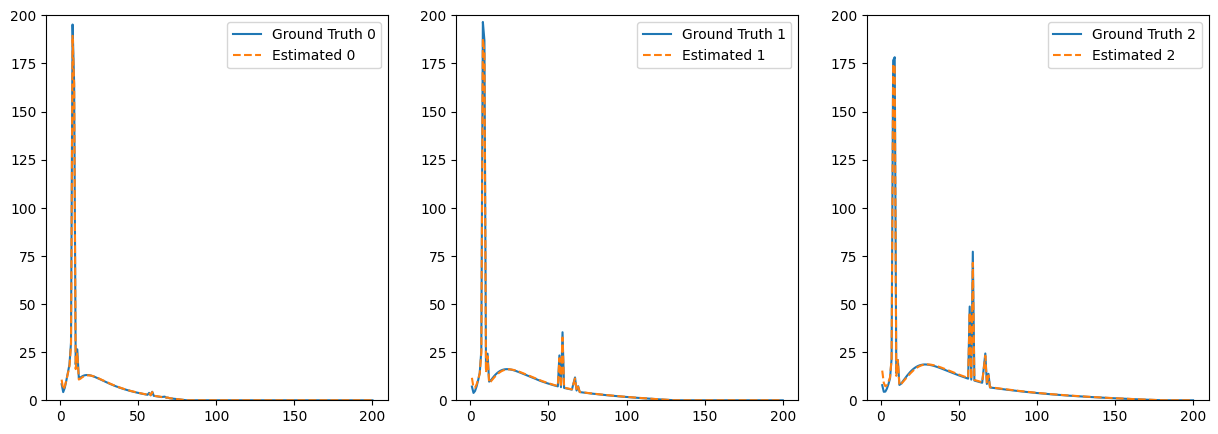

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 
for i in range(3):
    axs[i].plot(energies, ref_src_spec_list[i], label='Ground Truth %d'%i)
    axs[i].plot(energies, best_res.src_spec_list[i](energies).data, '--', label='Estimated %d' % i)
    axs[i].set_ylim((0,0.2e3))
    axs[i].legend()

## Filter

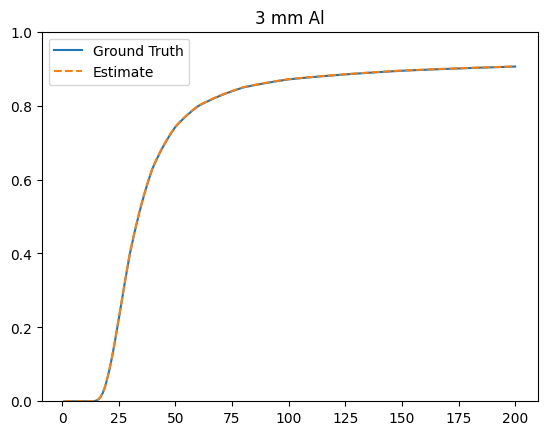

In [65]:
# Creating a figure with 3 subplots
ll = ['3 mm Al']

plt.plot(energies, ref_fltr_resp_list[0], label='Ground Truth')
plt.plot(energies, best_res.fltr_resp_list[0](energies).data, '--', label='Estimate')
plt.ylim((0,1))
plt.title(ll[0])
plt.legend()

## Scintillator

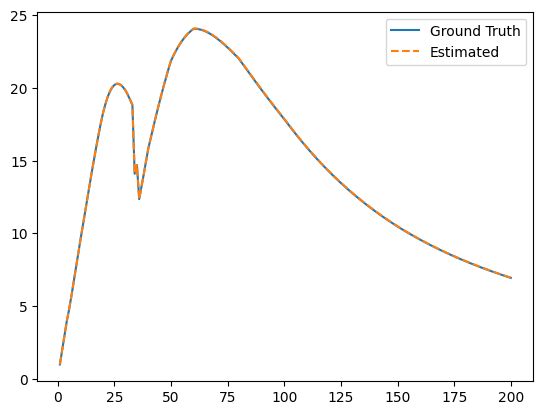

In [66]:
plt.plot(energies, ref_scint_cvt_list[0], label='Ground Truth')
plt.plot(energies, best_res.scint_cvt_list[0](energies).data, '--', label='Estimated')
plt.legend()